In [31]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.dates as mdates
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import gaussian_kde
import itertools
from statsmodels.compat import lzip
import pickle
import os

In [32]:

"""
Define figure parameters
"""
# image widths (inches from cm) for Elsevier
one_col = 9 / 2.54
half_pg = 14 / 2.54
full_pg = 19 / 2.54

# font sizes
font_xsml = 6
font_sml = 8
font_med = 10
font_lg = 12
font_xlg = 14

# resolution
dpi_out = 200

# save all figures?
save_all_figs = False

"""
Define input and output files and directories
"""
# output directories
outDIR_figs = './results/figures/'
outDIR_tables = './results/tables/'

# input directories and files
inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_04_26_hls_idxs_manual_combine.csv'

# extracted plot data
df_vor = pd.read_csv(os.path.join(inDIR, inFILE))

# linear model results
df_results = pd.read_csv("./results/VOR_lreg_results.csv")
df_results_full = pd.read_csv("./results/VOR_lreg_results_full.csv")

"""
Define necessary lists and dictionaries
"""
# variables used during model evaluation
all_vars = ['Pasture', 'Date', 'Plot', 'Biomass_kg_ha', 'Season', 'Color', 'Id', 'Year',
            'dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 'nir', 'swir1', 'swir2',
            'bai_126', 'bai_136', 'bai_146', 'bai_246', 'bai_236', 'bai_346',
            'pct_c3', 'pct_ann', 'pct_litt', 'pct_bare', 'pct_c3_ras']

# titles for the three model groups
xv_dict = {'simp': 'Features only',
           'pct_mg_ras': 'Features + MG-map',
           'pct_mg': 'Features + MG-plot'}

# variables used in model creation
var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_236', 'bai_246']

# formatted names for input variables
in_var_dict = {'dfi': 'DFI',
               'ndvi': 'NDVI',
               'ndti': 'NDTI',
               'satvi': 'SATVI',
               'ndii7': 'NDII7',
               'nir': 'NIR',
               'swir1': 'SWIR1',
               'swir2': 'SWIR2',
               'bai_126': 'BAI_126',
               'bai_136': 'BAI_136',
               'bai_236': 'BAI_236',
               'bai_246': 'BAI_246',
               'pct_c3': 'MG-plot',
               'pct_c3_ras': 'MG-map'}

# original names for input variables
var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

# grouping names for input variables
input_group_dict = {
    'DFI': 'Veg. Indices',
    'NDVI': 'Veg. Indices',
    'NDTI': 'Veg. Indices',
    'SATVI': 'Veg. Indices',
    'NDII7': 'Veg. Indices',
    'NIR': 'Bands',
    'SWIR1': 'Bands',
    'SWIR2': 'Bands',
    'BAI_126': 'BAIs',
    'BAI_136': 'BAIs',
    'BAI_236': 'BAIs',
    'BAI_246': 'BAIs',
    'MG-map': 'Veg. Community'
}

# directory in which to save each model type
mod_dir_dict = {'Temporal': '/Main/',
                'Spatial': '/Supp/'}

In [33]:
"""
Define necessary functions
"""

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', c='black')

In [34]:
"""
Preprocess data
"""
# change variables to lower-case
col_rename_dict = {x.upper(): x for x in var_names}
col_rename_dict['NIR1'] = 'nir'
df_vor = df_vor.rename(columns=col_rename_dict)

# subset only seasonal data
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])]

# set date structure and
df_vor['Date'] = pd.to_datetime(df_vor['Date'])

# remove any plots with missing data
df_vor.dropna(axis=0, how='any', subset=var_names + ['Biomass_kg_ha'], inplace=True)

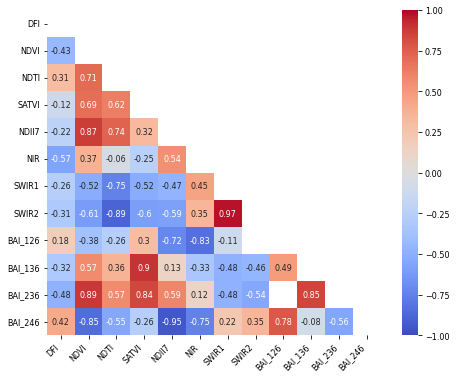

In [5]:
"""
Figure (Supplement): Correlation matrix for all input variables
"""
# define variables for correlation matrix
cor_vars_all = df_vor[var_names]

# create and save correlation matrix
from scipy.stats import pearsonr
corrMatrix = np.round(cor_vars_all.reset_index(drop=True).corr(), 2).rename(index=in_var_dict, columns=in_var_dict)
pvals = pd.DataFrame([[pearsonr(cor_vars_all[c],cor_vars_all[y])[1] for y in cor_vars_all.columns] for c in cor_vars_all.columns],
                     columns=cor_vars_all.columns, index=cor_vars_all.columns)
pvals_mask = pvals > 0.05
mask = np.zeros(corrMatrix.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
mask = pvals_mask.values | mask
fig = plt.figure(figsize=(full_pg, full_pg * 0.8))
ax = sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center=0, mask=mask, cmap='coolwarm',
                 annot_kws={"size": font_sml})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=font_sml)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=font_sml)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=font_sml)
if save_all_figs:
    plt.savefig(os.path.join(outDIR_figs, 'corrmatrix_inputs.png'), dpi=dpi_out, bbox_inches='tight', pad_inches=0.2)
    plt.close()

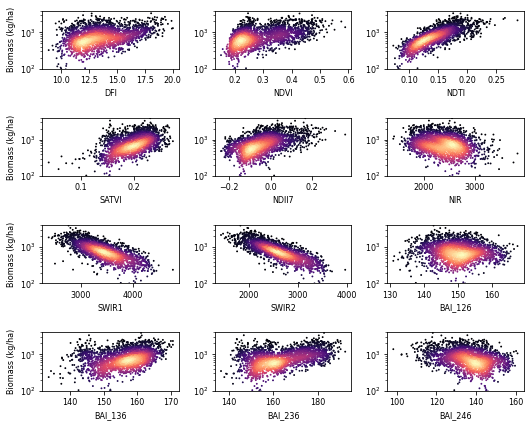

In [6]:
"""
Figure (Supplement): Correlations between model input variables and biomass
"""
fig, axs = plt.subplots(figsize=(full_pg, full_pg * 0.8), nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
for idx, v in enumerate(var_names):
    xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(100, 4000),
                            c=z_bm, cmap='magma', colorbar=False, s=0.75)
    if idx not in [0, 3, 6, 9]:
        axs.flatten()[idx].set_ylabel('', fontsize=font_sml)
    else:
        axs.flatten()[idx].set_ylabel('Biomass (kg/ha)', fontsize=font_sml)
    axs.flatten()[idx].set_xlabel(in_var_dict[v], fontsize=font_sml)
    axs.flatten()[idx].tick_params(axis='both', which='major', labelsize=font_sml)
plt.tight_layout(w_pad=0.75, h_pad=2.0)
if save_all_figs:
    plt.savefig(os.path.join(outDIR_fig, '/biomass_correllations.png'), dpi=dpi_out, bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [7]:
"""
Identify top models based on MAE, % MAE, R^2 and AIC
"""
# identify best models for each metric
df_results_best = pd.DataFrame(
    columns=['model', 'numb_vars', 'xv', 'min_MAE', 'min_MAE_pct', 'max_R2', 'min_AIC'])
for m in df_results['model'].unique():
    for n in df_results['numb_vars'].unique():
        for xv in df_results['xv'].unique():
            df_best_tmp = pd.DataFrame({'model': m,
                                        'numb_vars': n,
                                        'xv': xv,
                                        'min_MAE': df_results['mae_orig_mean'][(df_results['model'] == m) & \
                                                                               (df_results['numb_vars'] == n) & \
                                                                               (df_results['xv'] == xv)].min(),
                                        'min_MAE_pct': df_results['mae_pct_mean'][(df_results['model'] == m) & \
                                                                                  (df_results['numb_vars'] == n) & \
                                                                                  (df_results['xv'] == xv)].min(),
                                        'max_R2': df_results['R2_adj'][(df_results['model'] == m) & \
                                                                   (df_results['numb_vars'] == n) & \
                                                                   (df_results['xv'] == xv)].max(),
                                        'min_AIC': df_results['AIC'][(df_results['model'] == m) & \
                                                                     (df_results['numb_vars'] == n) & \
                                                                     (df_results['xv'] == xv)].min()},
                                       index=[0])
            df_results_best = pd.concat([df_results_best, df_best_tmp])

# identify top n models for each metric
ntop = 10
df_results_tops = pd.DataFrame(columns=df_results.columns)
for m in df_results['model'].unique():
    for n in df_results['numb_vars'].unique():
        for xv in df_results['xv'].unique():
            df_results_sub_tmp = df_results[(df_results['model'] == m) & \
                                            (df_results['numb_vars'] == n) & \
                                            (df_results['xv'] == xv)].sort_values(by='mae_orig_mean',
                                                                                  ascending=True)[:ntop]
            df_results_tops = pd.concat([df_results_tops, df_results_sub_tmp])
df_results_feats_best = pd.DataFrame(columns=['model', 'xv', 'features', 'count', 'oftotal'])
for m in df_results['model'].unique():
    for xv in df_results['xv'].unique():
        df_results_sub_tmp = df_results[(df_results['model'] == m) & \
                                        (df_results['xv'] == xv)].sort_values(by='mae_orig_mean',
                                                                              ascending=True)[:ntop]
        for f in var_names:
            df_results_feats_tmp = pd.DataFrame(dict(model=m,
                                                     xv=xv,
                                                     features=f,
                                                     count=np.sum([f in n for n in df_results_sub_tmp['formula']]),
                                                     oftotal=ntop),
                                                index=[0])
            df_results_feats_best = pd.concat([df_results_feats_best, df_results_feats_tmp])
    df_results_feats_best['pct'] = df_results_feats_best['count'].astype('float') / df_results_feats_best['oftotal'] \
        .astype('float32')

/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

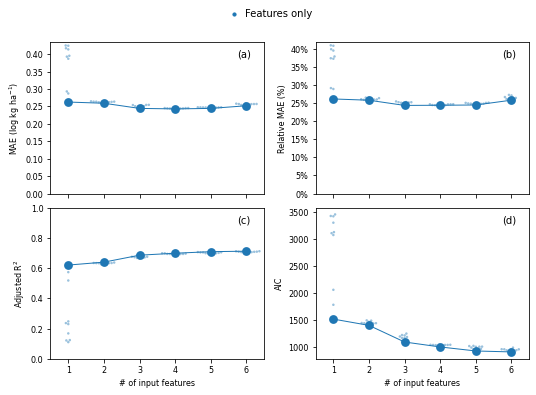

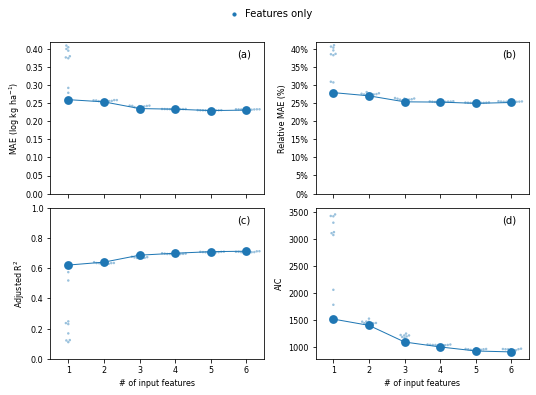

In [8]:

"""
Plot model performance of top models using temporal and spatial cross validation
"""
for mod_type in df_results_best.model.unique():
    fig = plt.figure(figsize=(full_pg, half_pg))
    ax1 = fig.add_subplot(2, 2, 1)
    pplot = sns.pointplot(x='numb_vars', y='min_MAE', hue='xv', data=df_results_best[df_results_best.model == mod_type],
                          hue_order=[x for x in xv_dict.keys() if x in df_results_best['xv'].unique()], 
                          ax=ax1)
    plt.setp(pplot.lines, zorder=10, linewidth=1.0)
    plt.setp(pplot.collections, zorder=10, label="")
    vplot = sns.swarmplot(x='numb_vars', y='mae_orig_mean', hue='xv',
                          data=df_results_tops[df_results_tops.model == mod_type],
                          hue_order=[x for x in xv_dict.keys() if x in df_results_best['xv'].unique()],
                          dodge=False, alpha=0.45, size=2.5, ax=ax1)
    plt.xlabel('')
    plt.ylabel('$\mathregular{MAE\ (log\ kg\ ha^{-1})}$', fontsize=font_sml)
    ax1.get_legend().remove()
    ax1.set_ylim(bottom=0.0)
    ax1.xaxis.set_major_formatter(mtick.NullFormatter())
    ax1.tick_params(axis='both', which='major', labelsize=font_sml)
    ax1.text(x=0.875, y=0.9, s='(a)', transform=ax1.transAxes, size=font_med)

    ax2 = fig.add_subplot(2, 2, 2)
    pplot2 = sns.pointplot(x='numb_vars', y='min_MAE_pct', hue='xv',
                           data=df_results_best[df_results_best.model == mod_type],
                           hue_order=[x for x in xv_dict.keys() if x in df_results_best['xv'].unique()],
                           ax=ax2)
    plt.setp(pplot2.lines, zorder=10, linewidth=1.0)
    plt.setp(pplot2.collections, zorder=10, label="")
    vplot2 = sns.swarmplot(x='numb_vars', y='mae_pct_mean', hue='xv',
                           data=df_results_tops[df_results_tops.model == mod_type],
                           hue_order=[x for x in xv_dict.keys() if x in df_results_best['xv'].unique()],
                           dodge=False, alpha=0.45, size=2.5, ax=ax2)
    plt.xlabel('')
    plt.ylabel('Relative MAE (%)', fontsize=font_sml)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
    ax2.xaxis.set_major_formatter(mtick.NullFormatter())
    ax2.tick_params(axis='both', which='major', labelsize=font_sml)
    ax2.text(x=0.875, y=0.9, s='(b)', transform=ax2.transAxes, size=font_med)
    ax2.get_legend().remove()

    ax3 = fig.add_subplot(2, 2, 3)
    pplot3 = sns.pointplot(x='numb_vars', y='max_R2', hue='xv', data=df_results_best[df_results_best.model == mod_type],
                           hue_order=[x for x in xv_dict.keys() if x in df_results_best['xv'].unique()],
                           ax=ax3)
    plt.setp(pplot3.lines, zorder=10, linewidth=1.0)
    plt.setp(pplot3.collections, zorder=10, label="")
    vplot3 = sns.swarmplot(x='numb_vars', y='R2_adj', hue='xv',
                           data=df_results_tops[df_results_tops.model == mod_type],
                           hue_order=[x for x in xv_dict.keys() if x in df_results_best['xv'].unique()],
                           dodge=False, alpha=0.45, size=2.5, ax=ax3)
    plt.xlabel('# of input features', fontsize=font_sml)
    plt.ylabel('$\mathregular{Adjusted~R^{2}}$', fontsize=font_sml)
    ax3.get_legend().remove()
    ax3.set_ylim(bottom=0.0, top=1.0)
    ax3.tick_params(axis='both', which='major', labelsize=font_sml)
    ax3.text(x=0.875, y=0.9, s='(c)', transform=ax3.transAxes, size=font_med)

    ax4 = fig.add_subplot(2, 2, 4)
    pplot4 = sns.pointplot(x='numb_vars', y='min_AIC', hue='xv', data=df_results_best[df_results_best.model == mod_type],
                           hue_order=[x for x in xv_dict.keys() if x in df_results_best['xv'].unique()],
                           ax=ax4)
    plt.setp(pplot4.lines, zorder=10, linewidth=1.0)
    plt.setp(pplot4.collections, zorder=10, label="")
    vplot4 = sns.swarmplot(x='numb_vars', y='AIC', hue='xv',
                           data=df_results_tops[df_results_tops.model == mod_type],
                           hue_order=[x for x in xv_dict.keys() if x in df_results_best['xv'].unique()],
                           dodge=False, alpha=0.45, size=2.5, ax=ax4)
    plt.xlabel('# of input features', fontsize=font_sml)
    plt.ylabel('AIC', fontsize=font_sml)
    ax4.get_legend().remove()
    ax4.tick_params(axis='both', which='major', labelsize=font_sml)
    ax4.text(x=0.875, y=0.9, s='(d)', transform=ax4.transAxes, size=font_med)

    leg2handles, leg2labels = ax2.get_legend_handles_labels()
    for handle in leg2handles:
        handle.set_sizes([10])
    ax2.set_ylim(bottom=0)
    plt.figlegend(leg2handles, [xv_dict[l] for l in leg2labels], fontsize=font_med,
                  loc='upper center', ncol=3, columnspacing=0.5, handletextpad=0.1, frameon=False)

    plt.tight_layout(h_pad=0.5, rect=(0, 0, 1, 0.925))
    if save_all_figs:
        plt.savefig(os.path.join(outDIR_figs, mod_type + '_model_performance_top' + str(ntop) + '.png'),
                                 dpi=dpi_out, bbox_inches='tight', pad_inches=0.2)
        plt.close()

In [9]:

"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 4

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_results_feats_ptn = pd.DataFrame(columns=['model', 'xv', 'kfold', 'features', 'formula', 'RVI', 'weight'])
for m in df_results_full['model'].unique():
    for xv in df_results_full['xv'].unique():
        for k in df_results_full['kfold'].unique():
            df_results_sub_tmp = df_results_full[(df_results_full['model'] == m) &
                                                 (df_results_full['xv'] == xv) &
                                                 (df_results_full['kfold'] == k) &
                                                 (df_results_full['numb_vars'] <= max_vars)].copy()
            df_results_sub_tmp['AICw'] = df_results_sub_tmp['AIC'] \
                .transform(lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min()))))
            for f in var_names:
                df_results_sub_f = df_results_sub_tmp[[f in n for n in df_results_sub_tmp['formula']]]
                if len(df_results_sub_f) == 0:
                    continue
                else:
                    for f_form in df_results_sub_f['formula']:
                        f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                                re.sub(" \+ " + f + ":[^\+]*", "",
                                                       re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                              re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                                     re.sub("\+ " + f + " (?=\+)", "",
                                                                            re.sub("(?<=~ )" + f + " \+ ", "",
                                                                                   f_form))))))

                        # print(f_form)
                        # print(f_form_omitted)
                        RVI_tmp = df_results['R2'][(df_results['formula'] == f_form) &
                                                   (df_results['model'] == m)].values - \
                                  df_results['R2'][(df_results['formula'] == f_form_omitted) & \
                                                   (df_results['model'] == m)].values
                        OVI_tmp = df_results['mae_orig_mean'][(df_results['formula'] == f_form) & \
                                                              (df_results['model'] == m)].values - \
                                  df_results['mae_orig_mean'][(df_results['formula'] == f_form_omitted) & \
                                                              (df_results['model'] == m)].values
                        weight_tmp = df_results_sub_tmp['AICw'][(df_results_sub_tmp['formula'] == f_form) & \
                                                                (df_results_sub_tmp['model'] == m)].values

                        df_results_feats_tmp = pd.DataFrame(dict(model=m,
                                                                 xv=xv,
                                                                 kfold=k,
                                                                 features=in_var_dict[f],
                                                                 formula=f_form,
                                                                 RVI=np.mean(RVI_tmp),
                                                                 weight=weight_tmp),
                                                            index=[0])
                        df_results_feats_ptn = pd.concat([df_results_feats_ptn, df_results_feats_tmp])

# calculate weighted relative variable importance (RVIw)
df_results_feats_ptn['RVIw'] = df_results_feats_ptn['RVI'] * df_results_feats_ptn['weight']

# add input variable group field
df_results_feats_ptn['group'] = [input_group_dict[f] for f in df_results_feats_ptn['features']]

# calculate sorted mean RVIw for each feature after summing across each kfold
df_results_feats_grp = df_results_feats_ptn.groupby(['model',
                                                     'kfold',
                                                     'features',
                                                     'xv',
                                                     'group'])['RVIw'].sum().reset_index()
df_results_feats_grp['RVIw_mean'] = df_results_feats_grp.groupby(['model', 'xv', 'features'])['RVIw'].transform('mean')
df_results_feats_grp = df_results_feats_grp.groupby(['model', 'xv']) \
    .apply(lambda x: x.sort_values(['RVIw_mean'], ascending=False)).reset_index(drop=True)

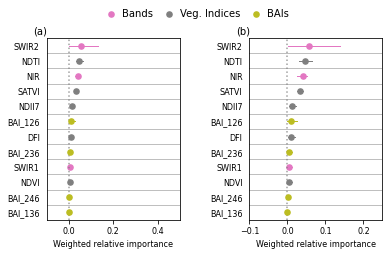

In [11]:

"""
Figure: Plot variable importance calculated from all model subsets
"""
fig = plt.figure(figsize=(half_pg, half_pg * 0.65))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Bands', 'Veg. Indices', 'BAIs'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', scale=0.75,
                       palette=sns.color_palette()[6:],
                       errwidth=1.0,
                       data=df_results_feats_grp[(df_results_feats_grp['xv'] == 'simp') &
                                                 (df_results_feats_grp['model'] == 'Temporal')])
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_results_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

ax2 = fig.add_subplot(1, 2, 2)
sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Bands', 'Veg. Indices', 'BAIs'],
              orient='h', dodge=False, ax=ax2, linestyles='None', errwidth=1.0, scale=0.75,
              palette=sns.color_palette()[6:],
              data=df_results_feats_grp[(df_results_feats_grp['xv'] == 'simp') &
                                        (df_results_feats_grp['model'] == 'Temporal')])
ax2.set_ylabel('')
ax2.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax2.get_legend().remove()
ax2.set_xlim((-0.10, 0.250))
ax2.set_yticks(np.arange(0.5, len(df_results_feats_grp['features'].unique()) - 1, 1), minor=True)
ax2.grid(which='minor', axis='y')
for tic in ax2.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax2.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax2.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax2.tick_params(axis='x', which='major', labelsize=font_sml)
ax2.tick_params(axis='y', which='major', labelsize=font_sml)
ax2.text(x=-0.1, y=1.025, s='(b)', transform=ax2.transAxes, size=font_med)

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_all_figs:
    plt.savefig(os.path.join(outDIR_figs, 'variable_importance_temporal_and_spatial.png'), dpi=dpi_out,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [12]:

"""
Create and save tables for top candidate models (at least one AICw > 0.50), sorted by MAE
"""
# calculate AIC weights (AICw) for all models with fewer than max_vars
df_results_full_sub = df_results_full[df_results_full['numb_vars'] <= max_vars].copy()
df_results_full_sub['AICw'] = df_results_full_sub.groupby(['model', 'xv', 'kfold'])['AIC'] \
    .transform(lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min()))))

# Calculate AIC rank within model group and K-fold, then tally number of times a model is best based on AIC
df_results_full_sub['AIC_rank'] = df_results_full_sub.groupby(['model', 'xv', 'kfold'])['AIC'].rank()
df_results_full_sub['AIC_tally'] = df_results_full_sub.groupby(['model', 'xv', 'formula'])['AIC_rank'] \
    .transform(lambda x: np.sum(x[x == 1]))

# Get stats by model
df_results_full_grp = df_results_full_sub.groupby(['model', 'xv', 'formula']).mean().reset_index()
for col in ['mae_orig', 'mae_kg', 'mae_pct', 'AIC', 'AICw', 'R2', 'pe']:
    df_results_full_grp[col + '_sd'] = df_results_full_sub.groupby(['model', 'xv', 'formula']).std().reset_index()[col]
for col in ['AICw', 'mae_kg']:
    df_results_full_grp[col + '_max'] = df_results_full_sub.groupby(['model', 'xv', 'formula']).max().reset_index()[col]

# define fields to include in saved tables
out_features = ['xv', 'formula',
                'mae_orig', 'mae_orig_sd',
                'mae_kg', 'mae_kg_sd', 'mae_pct', 'mae_pct_sd', 'pe', 'pe_sd',
                'AICw', 'AICw_sd', 'AICw_max', 'R2', 'R2_sd']

# save tables as .csv's, sorted by log-transformed MAE
for mod_type in df_results_full_grp['model'].unique():
    for xv in ['simp']:
        table_tmp = df_results_full_grp.loc[(df_results_full_grp['xv'] == xv) &
                                            (df_results_full_grp['AICw_max'] >= 0.50) &
                                            (df_results_full_grp['model'] == mod_type),
                                            out_features].sort_values('mae_orig', ascending=True)
        table_tmp['formula'] = table_tmp['formula'].map(
            lambda x: 'Y ~ ' + ' + '.join([in_var_dict[v] for v in re.sub('np\.log\(Biomass_kg_ha\) ~ ', '', x)
                                          .split(' + ') if v in in_var_dict.keys()]))
        table_tmp['mae_orig'] = table_tmp['mae_orig'].map(lambda x: '{:.4f}'.format(x))
        table_tmp['mae_orig_sd'] = table_tmp['mae_orig_sd'].map(lambda x: '(' + '{:.4f}'.format(x) + ')')
        table_tmp['mae_kg'] = table_tmp['mae_kg'].map(lambda x: '{:.2f}'.format(x))
        table_tmp['mae_kg_sd'] = table_tmp['mae_kg_sd'].map(lambda x: '(' + '{:.2f}'.format(x) + ')')
        table_tmp['mae_pct'] = table_tmp['mae_pct'].map(lambda x: '{:.1%}'.format(x))
        table_tmp['mae_pct_sd'] = table_tmp['mae_pct_sd'].map(lambda x: '(' + '{:.1%}'.format(x) + ')')
        table_tmp['pe'] = table_tmp['pe'].map(lambda x: '{:.1%}'.format(x))
        table_tmp['pe_sd'] = table_tmp['pe_sd'].map(lambda x: '(' + '{:.1%}'.format(x) + ')')
        table_tmp['AICw'] = table_tmp['AICw'].map(lambda x: '{:.2f}'.format(x))
        table_tmp['AICw_sd'] = table_tmp['AICw_sd'].map(lambda x: '(' + '{:.2f}'.format(x) + ')')
        table_tmp['AICw_max'] = table_tmp['AICw_max'].map(lambda x: '{:.2f}'.format(x))
        table_tmp['R2'] = table_tmp['R2'].map(lambda x: '{:.2f}'.format(x))
        table_tmp['R2_sd'] = table_tmp['R2_sd'].map(lambda x: '(' + '{:.2f}'.format(x) + ')')
        if save_all_figs:
            table_tmp.to_excel(os.path.join(outDIR_tables, 'candidate_models_' + xv + '_table_' + mod_type + '_v3.xlsx'),
                               index=False)
        else:
            print(table_tmp)

       xv                              formula mae_orig mae_orig_sd  mae_kg  \
194  simp            Y ~ DFI + SWIR1 + BAI_236   0.2342    (0.0302)  208.31   
309  simp               Y ~ NDTI + SATVI + NIR   0.2343    (0.0282)  209.41   
425  simp  Y ~ SATVI + NDII7 + SWIR2 + BAI_126   0.2348    (0.0291)  210.46   
271  simp     Y ~ NDTI + NDII7 + NIR + BAI_236   0.2352    (0.0274)  211.58   
304  simp       Y ~ NDTI + SATVI + NDII7 + NIR   0.2355    (0.0263)  210.43   
436  simp    Y ~ SATVI + NIR + SWIR2 + BAI_246   0.2359    (0.0317)  209.19   

    mae_kg_sd mae_pct mae_pct_sd    pe    pe_sd  AICw AICw_sd AICw_max    R2  \
194   (33.01)   25.4%     (9.3%)  5.0%  (11.8%)  0.13  (0.30)     0.94  0.70   
309   (34.54)   25.5%     (9.6%)  4.9%  (11.3%)  0.30  (0.31)     1.00  0.70   
425   (32.67)   25.6%     (9.4%)  4.8%  (11.6%)  0.10  (0.31)     0.99  0.70   
271   (37.95)   25.7%     (9.5%)  5.0%  (11.0%)  0.08  (0.26)     0.82  0.70   
304   (34.26)   25.6%     (9.5%)  5.0%  (11.3%

In [35]:
# define final model
lr_form_fnl_simp = df_results_full_grp['formula'][309]

# define final model parameters
log_xfrm = True
wtd = False

# change column names back to lower case for prediction
df_vor = df_vor.rename(columns=var_dict)

# save models as objects
if wtd:
    lreg_all = smf.wls(formula=lr_form_fnl_simp,
                            data=df_vor,
                            weights=1 / df_vor['Biomass_kg_ha']).fit()
else:
    lreg_all = smf.ols(formula=lr_form_fnl_simp,
                            data=df_vor).fit()
    
# print test of normality of residuals for final models
name = ['Chi^2', 'Two-tail probability']
hs_test_simp = sms.diagnostic.lilliefors(lreg_all.resid, pvalmethod='table')
print(lzip(name, hs_test_simp))

[('Chi^2', 0.027160901929643516), ('Two-tail probability', 0.0009999999999998899)]


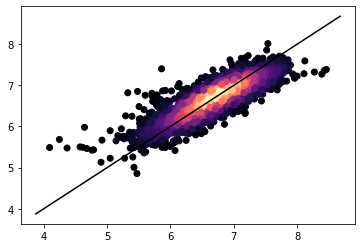

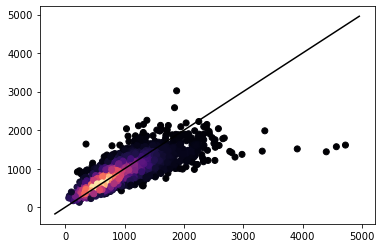

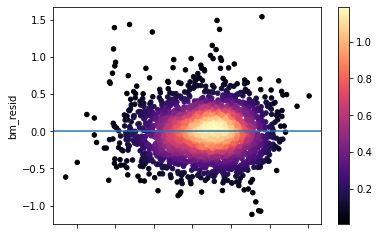

In [36]:
if log_xfrm:
    df_vor['bm_pred_lr'] = lreg_all.predict(df_vor)
    xy_bm = np.vstack([df_vor['bm_pred_lr'], np.log(df_vor['Biomass_kg_ha'])])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    plt.figure()
    plt.scatter(np.log(df_vor['Biomass_kg_ha']), df_vor['bm_pred_lr'], c=z_bm, cmap='magma')
    abline(1, 0)

    xy_bm = np.vstack([np.exp(df_vor['bm_pred_lr']), df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    plt.figure()
    plt.scatter(df_vor['Biomass_kg_ha'], np.exp(df_vor['bm_pred_lr']), c=z_bm, cmap='magma')
    abline(1, 0)

    df_vor['bm_resid'] = df_vor['bm_pred_lr'] - np.log(df_vor['Biomass_kg_ha'])
    xy_bm_resid = np.vstack([df_vor['bm_resid'], df_vor['bm_pred_lr']])
    z_bm_resid = gaussian_kde(xy_bm_resid)(xy_bm_resid)
    df_vor.plot.scatter(x='bm_pred_lr', y='bm_resid', c=z_bm_resid, cmap='magma')
    plt.axhline(y=0)
else:
    df_vor['bm_pred_lr'] = lreg_all.predict(df_vor)
    xy_bm = np.vstack([df_vor['bm_pred_lr'], df_vor['Biomass_kg_ha']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    plt.figure()
    plt.scatter(df_vor['Biomass_kg_ha'], df_vor['bm_pred_lr'], c=z_bm, cmap='magma')
    abline(1, 0)

    df_vor['bm_resid'] = df_vor['bm_pred_lr'] - df_vor['Biomass_kg_ha']
    xy_bm_resid = np.vstack([df_vor['bm_resid'], df_vor['bm_pred_lr']])
    z_bm_resid = gaussian_kde(xy_bm_resid)(xy_bm_resid)
    df_vor.plot.scatter(x='bm_pred_lr', y='bm_resid', c=z_bm_resid, cmap='magma')
    plt.axhline(y=0)

In [39]:
# save final models to disk for future prediction
pickle.dump(lreg_all_simp, open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_20230707.pk", 'wb'))

# save final model summaries as .csv tables
f = open('../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_20230707_summary.csv', 'w')
f.write(lreg_all_simp.summary().as_csv())
f.close()